# Genetic Algorithm Practice 

Can you help Santa to find a path to visit each city while minimizing the total distance travelled? Santa must start and end in the North Pole, the first city on the list.

The dataset size is 197769, so that a brute force search would need
197769! function evaluations. 197769! has rougly 961528 digits (by Kametsky's approximation), which is quite daunting.

We will instead use a genetic algorithm to generate a "good enough" solution.

Data source: Kaggle Prime Path's competition: https://www.kaggle.com/competitions/traveling-santa-2018-prime-paths/

 ## Tasks
 
1. Implement a distance calculation function that gives the total euclidian distance for a given path through the cities. A path can be defined as an integer valued array which specificies the order in which the cities are visited. Note that the condition of starting and ending in the same city means that you do not need to specify the first city in a path, but you need to include it in the calculation of the distance function.
 
 
2. Calculate the run-time of a brute force approach as you increase the number of cities. You can stop when you reach 1 minute run-time. Plot the run-time as a function of the number of cities. You can use the 'permutations' function from itertools to get an exhaustive list of possible paths.

3. Fill in the missing crossover and mutation operations in the genetic algorithm and run it for a few different problem sizes. Compare it's performance to the exhaustive search for some small problem sizes (circa 10 cities). You can get an overview of possible crossover operations from the following article https://user.ceng.metu.edu.tr/~ucoluk/research/publications/tspnew.pdf

Bonus. Rewrite the genetic algorithm using numpy arrays. It should be possible to use fewer lines of code that also executes faster.

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from multiprocessing import Pool

In [2]:
citydata = pd.read_csv("data/cities.csv")

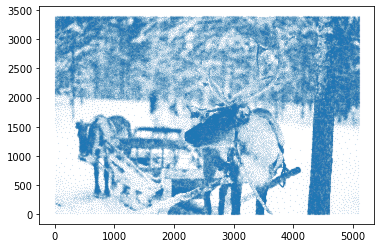

In [3]:
plt.scatter(citydata["X"], citydata["Y"], s = 0.005)

In [4]:
def distance(px,py, x,y):
    return np.sqrt((x - px)**2 + (y - py)**2)

def total_distance(path, cities_df_dict):
    pass

In [5]:
import time
from itertools import permutations

def brute_force_search(citydata):
    pass

def run_times(N):
    pass
        
#You can tune the number of cities yourself to get circa a minute of run-time
sizes, times = run_times(8)
plt.plot(sizes, times)
plt.xlabel("Number of cities")
plt.ylabel("Run time (s)")

TypeError: cannot unpack non-iterable NoneType object

 ### What is the path length if we simply visit the cities in order?

In [ ]:
simplepath  = citydata.CityId[:].values[1:]
score = total_distance(simplepath, citydata.to_dict())
print('Total distance visiting cities in order is '+ "{:,}".format(score))

### Genetic algorithm solution


Outline of the basic genetic algorithm

* [Start] Generate random population of n chromosomes (suitable solutions for the problem)
* [Fitness] Evaluate the fitness f(x) of each chromosome x in the population
    * [New population] Create a new population by repeating following steps until the new population is complete
    * [Selection] Select two parent chromosomes from a population according to their fitness (the better fitness, the bigger chance to be selected)
    * [Crossover] With a crossover probability cross over the parents to form a new offspring (children). If no crossover was performed, offspring is an exact copy of parents.
    * [Mutation] With a mutation probability mutate new offspring at each locus (position in chromosome).
    * [Accepting] Place new offspring in a new population
* [Replace] Use new generated population for a further run of algorithm
* [Test] If the end condition is satisfied, stop, and return the best solution in current population
* [Loop] Go to step 2

Source: https://www.obitko.com/tutorials/genetic-algorithms/ga-basic-description.php

In [ ]:
class GeneticAlgorithm(object):
    def __init__(self, genetics):
        self.genetics       = genetics
        self.best_solution  = None
        self.avg_fitness    = []
        self.max_fitness =    []
        self.min_fitness =    []
        
    def fitness(self, ch):
        return (self.genetics.fitness(ch),  ch)
    
    def run(self, processes=4):
        population = self.genetics.initial()
        pool       = Pool(processes=processes)
        
        while True:
            #fits_pops = [self.fitness(ch) for ch in population]
            fits_pops  = pool.map(self.fitness, population)
            
            #Rank the solutions according to fitness
            fits_pops = list(sorted(fits_pops, reverse = True))
            
            # Log
            self.avg_fitness.append(np.mean([f for f, ch in fits_pops]))
            self.max_fitness.append(np.max([f for f, ch in fits_pops]))
            self.min_fitness.append(np.min([f for f, ch in fits_pops]))
            
            self.best_solution = fits_pops[0][1]
            
            if self.genetics.check_stop(fits_pops): 
                break
            
            population = self.next(fits_pops)
        return population

    def next(self, fits):
        parents_generator = self.genetics.parents(fits)
        size  = len(fits)
        
        nexts = [self.best_solution.copy()]
       
        while len(nexts) < size:
            parents  = next(parents_generator)
            cross    = random.random() < self.genetics.probability_crossover
            children = self.genetics.crossover(parents) if cross else parents

            for ch in children:
                mutate = random.random() < self.genetics.probability_mutation
                nexts.append(self.genetics.mutation(ch) if mutate else ch)
        return nexts[0:size]

In [ ]:
class TravelingSanta():
    def __init__(self, 
                 citydata, 
                 generations=10,
                 size=5,
                 prob_crossover=0.9, 
                 prob_mutation=0.2,
                 mutation_frac = 0.05):
        
        self.citydata  = citydata
        self.counter   = 0
        
        self.generations = generations
        self.size  = size        
        self.probability_crossover = prob_crossover
        self.probability_mutation  = prob_mutation
        self.mutation_frac = mutation_frac
        
        self.citydata_dict = citydata.to_dict()
        print("Generation best average worst")

    # Initial population based in s0
    def initial(self):
        population = [self.random_chromo() for j in range(self.size)]
        return population

    def fitness(self, chromo):
        #Negative since smaller distances are better
        score = -1*total_distance(chromo, self.citydata_dict)
        return score

    def check_stop(self, fits_populations):
        self.counter += 1
        
        if self.counter % 2 == 0:
            fits  = [f for f, ch in fits_populations]
            best  = max(fits)
            worst = min(fits)
            ave   = sum(fits) / len(fits)
            print("G{:3d} {:.2f} {:.2f} {:.2f}".format(self.counter, best, ave, worst))
            #print("[G %3d] %2f, %2f, %2f" %
            #    (self.counter, best, ave, worst))
            
        return self.counter >= self.generations

    def parents(self, fits_populations):
        #Random mating
        while True:
            father = self.tournament(fits_populations)
            mother = self.tournament(fits_populations)
            yield (father, mother)

    def crossover(self, parents):
        pass

    def mutation(self, chromosome):
        pass

    def tournament(self, fits_populations):
        alicef, alice = self.select_random(fits_populations)
        bobf, bob = self.select_random(fits_populations)
        return alice if alicef < bobf else bob

    def select_random(self, fits_populations):
        return fits_populations[random.randint(0, len(fits_populations)-1)]

    def random_chromo(self):
        chromo = list(self.citydata.CityId.sample(frac=1).values)
        return chromo

 ## Genetic algorithm solution for a reasonable problem size

In [ ]:
num_cities = 500
generations      = 100
population_size = 100
prob_crossover  = 0.5
prob_mutation   = 0.2
mutation_frac = 0.5

ga = GeneticAlgorithm(
     TravelingSanta(citydata[:num_cities], 
                    generations=generations,
                    size=population_size, 
                    prob_crossover=prob_crossover,
                    prob_mutation=prob_mutation, 
                    mutation_frac = mutation_frac))

latest_pop = ga.run()

In [ ]:
total_distance(ga.best_solution, citydata.to_dict())

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(-1*np.array(ga.avg_fitness), label = "average")
ax.plot(-1*np.array(ga.min_fitness), label = "min")
ax.plot(-1*np.array(ga.max_fitness), label = "max")
ax.legend(loc = 5)
ax.set_ylabel("Total distance traveled")
ax.set_xlabel("Generation")

## Compare genetic algorithm solution to brute force search

## Check that your solutions are valid with this function

In [ ]:
def validate_solution(sol):
    assert len(np.unique(sol)) == len(sol)
    
validate_solution(ga.best_solution)